In [ ]:
%%bash
git clone https://github.com/jthickstun/gm-hw3
wget https://courses.cs.washington.edu/courses/cse599i/20au/resources/hw3data.tar.gz
tar -xf hw3data.tar.gz

In [1]:
import sys,os,signal
from time import time

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torchvision import transforms

from IPython import display

sys.path.append('gm-hw3')
import cifar, models, utils, inception

root = 'data/'

In [2]:
def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN)
    
batch_size = 256
kwargs = {'num_workers': 2, 'pin_memory': True, 'worker_init_fn': worker_init}

train_set = cifar.CIFAR10(root=root, train=True, one_hot=True, transform=transforms.ToTensor(),download=True)
test_set = cifar.CIFAR10(root=root, train=False, one_hot=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False, **kwargs)

Files already downloaded and verified


In [3]:
seed_size = 128

g = models.Generator(seed_size).cuda()
f = models.Discriminator().cuda()

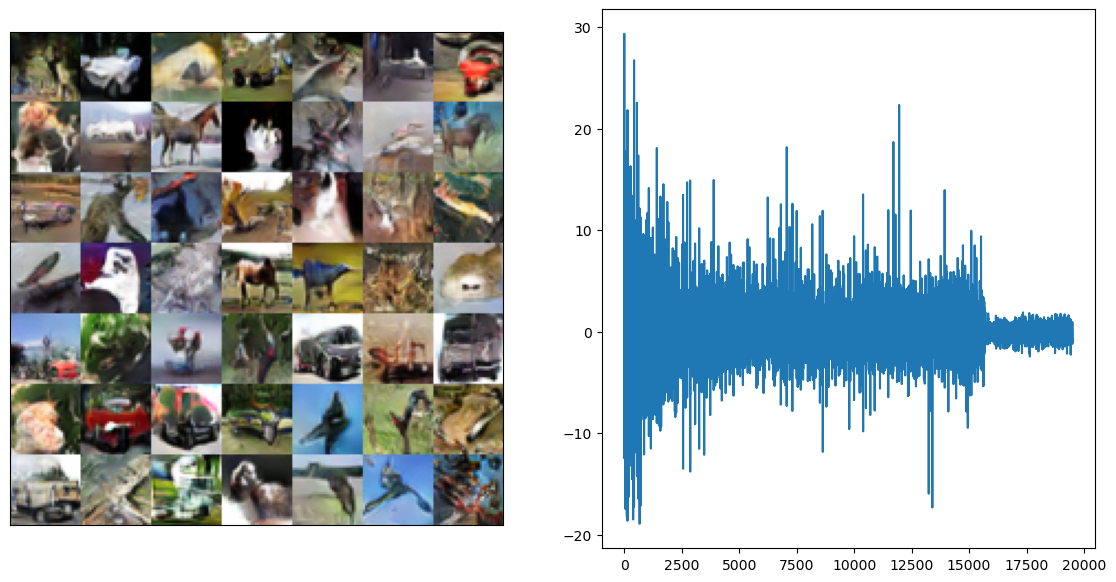

19500 6.780763864517212 7.773842


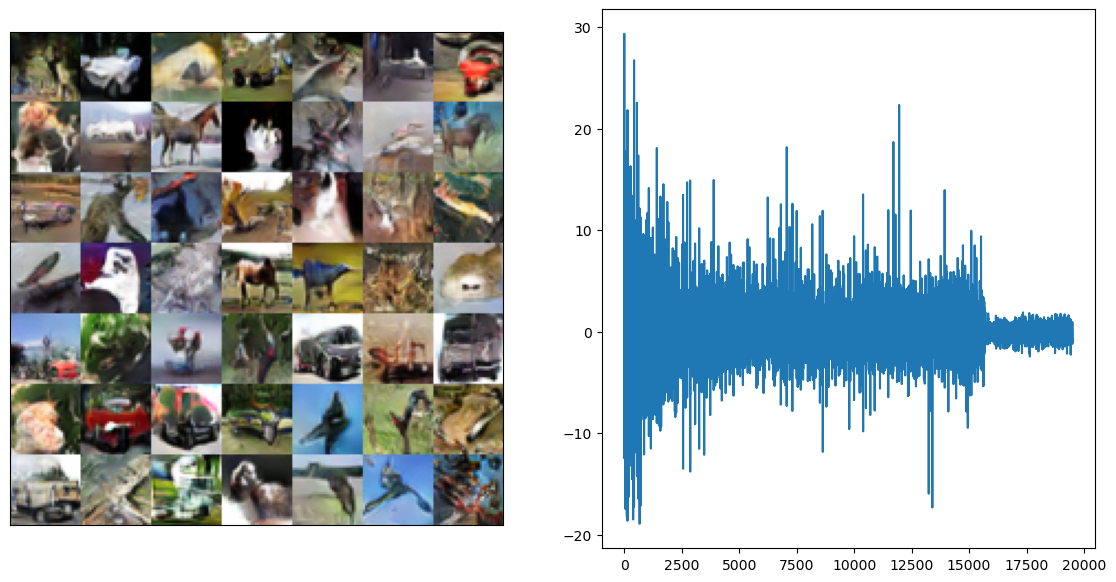

In [5]:
fig, ax = plt.subplots(1,2,figsize=(14,7))

lr = 3e-4

foptimizer = torch.optim.Adam(f.parameters(), lr=lr, betas=(0,0.9))
goptimizer = torch.optim.Adam(g.parameters(), lr=lr, betas=(0,0.9))

losses = []

i = 0
t0 = time()
scores = []
epochs = 100
for epoch in range(epochs):
    for x,_ in train_loader:
        x = x.cuda()
        
        cur_bs = x.size(0)
        z      = torch.randn(cur_bs, seed_size, device=x.device)
        fake   = g(z)

        foptimizer.zero_grad(set_to_none=True)
        real_score = f(x).view(-1)
        fake_score = f(fake.detach()).view(-1)
        wasserstein = fake_score.mean() - real_score.mean()

        gp = 10.0 * models.gradient_penalty(f, x, fake.detach())
        d_loss = wasserstein + gp
        d_loss.backward()
        foptimizer.step()

        goptimizer.zero_grad(set_to_none=True)
        g_loss = -f(fake).view(-1).mean()                    
        g_loss.backward()
        goptimizer.step()

        loss = g_loss                                        
        losses.append(loss.detach().cpu().numpy())

        if epoch == 80:                                      
            for opt in (foptimizer, goptimizer):
                for pg in opt.param_groups:
                    pg['lr'] = 3e-5
        
        if i % 100 == 0:
            g.eval()
            y = g(torch.randn(batch_size, seed_size).cuda())
            display.clear_output(wait=True)
            utils.print_images(y.detach().cpu().numpy(), ax[0])
            ax[1].cla(); ax[1].plot(losses)
            display.display(plt.gcf())
            scores.append(inception.score(g, 1000, 100))
            print(i, time()-t0, scores[-1])
            g.train()
            t0 = time()
        i += 1

Final inception score: 7.924052


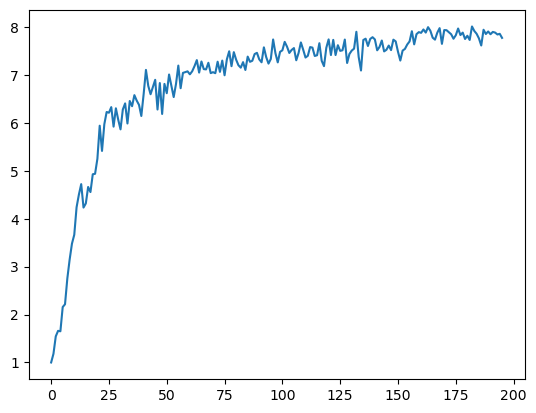

In [6]:
plt.plot(scores)

g.eval()
print("Final inception score:", inception.score(g, 50000, 100))
g.train();